In [ ]:
'''
Get submission for Clip -> Feed Forward Model
'''
from model_data import PriceModel, PriceDataset, collate_function, SMAPELoss
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
use_log_scale=True
test_dataset = PriceDataset(annotations_file='student_resource/dataset/test_focused.csv', image_dir='test_images', content_col='focused_sentence',
                            return_target=False, use_log_scale=use_log_scale)

batch_size = 256
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, collate_fn=collate_function, num_workers = 4)

base_checkpoint = 'google/siglip2-large-patch16-256'
checkpoint = 'output/best.pth'
model = PriceModel(base_checkpoint, cache_dir = 'hf_models')
model.load_checkpoint(checkpoint=checkpoint)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
torch.cuda.empty_cache()
gc.collect()

89

In [4]:
# batch = next(iter(test_loader))
# batch

In [5]:
# check_dataset = torch.utils.data.Subset(test_dataset, list(range(1000)))
# check_loader = DataLoader(dataset=check_dataset, batch_size=256, shuffle=False, collate_fn = collate_function)

In [6]:
all_predictions = None
model.eval()
n_steps = len(test_loader)
with torch.inference_mode():
    # for batch in tqdm(check_loader, total=len(check_loader)):
    for batch in tqdm(test_loader, total=len(test_loader)):
        images, texts, _ = batch
        # targets = targets.to(device=model.backbone.device)
        predictions = model(images, texts)
        if all_predictions is not None:
            all_predictions = torch.cat([all_predictions, predictions.detach().cpu()])
        else:
            all_predictions  = predictions.detach().cpu()


100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [1:05:21<00:00, 13.38s/it]


In [7]:
test_df = test_dataset.annotations.copy()
test_df

,sample_id,image_link,focused_sentence
0,100179,https://m.media-amazon.com/images/I/71hoAn78AW...,Item Name: Rani 14-Spice Eshamaya's Mango Chut...
1,245611,https://m.media-amazon.com/images/I/61ex8NHCIj...,Item Name: Natural MILK TEA Flavoring extract ...
2,146263,https://m.media-amazon.com/images/I/61KCM61J8e...,Item Name: Honey Filled Hard Candy - Bulk Pack...
3,95658,https://m.media-amazon.com/images/I/51Ex6uOH7y...,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...
4,36806,https://m.media-amazon.com/images/I/71QYlrOMoS...,"Item Name: McCormick Culinary Vanilla Extract,..."
...,...,...,...
74995,93616,https://m.media-amazon.com/images/I/51e9H27lgv...,Item Name: Good Seasons Zezty Italian Salad Dr...
74996,249434,https://m.media-amazon.com/images/I/61IpkExmVt...,"Item Name: Colombina Swirled Love Tiger Pops, ..."
74997,162217,https://m.media-amazon.com/images/I/A1NMggyCLz...,"Item Name: Kerns, Guava Nectar, 11.5 Fl Oz Can..."
74998,230487,https://m.media-amazon.com/images/I/81P69kEP5q...,Item Name: NY SPICE SHOP Licorice Candy - 1 Po...


In [8]:
test_df['price'] = torch.expm1(all_predictions) if use_log_scale else all_predictions

(array([4.4239e+04, 2.0529e+04, 5.8960e+03, 2.3120e+03, 1.2200e+03,
        5.3400e+02, 1.9500e+02, 5.5000e+01, 1.8000e+01, 2.0000e+00]),
 array([  0.78618371,  16.85425186,  32.92232132,  48.99039078,
         65.05845642,  81.12652588,  97.19459534, 113.26266479,
        129.33073425, 145.39880371, 161.46687317]),
 <BarContainer object of 10 artists>)

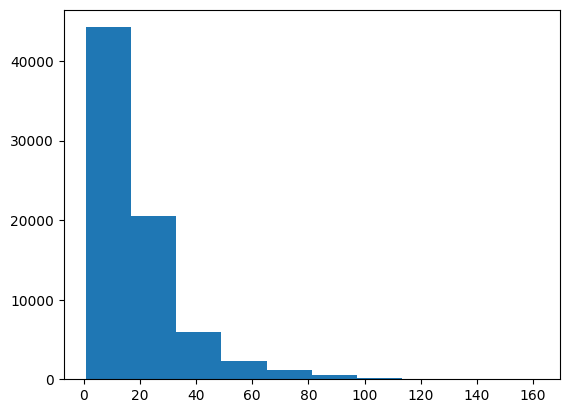

In [9]:
plt.hist(test_df['price'])

{'whiskers': [<matplotlib.lines.Line2D at 0x21a5691c0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x21a5691c6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21a568f7d60>],
 'medians': [<matplotlib.lines.Line2D at 0x21a5691cca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21a5691cfa0>],
 'means': []}

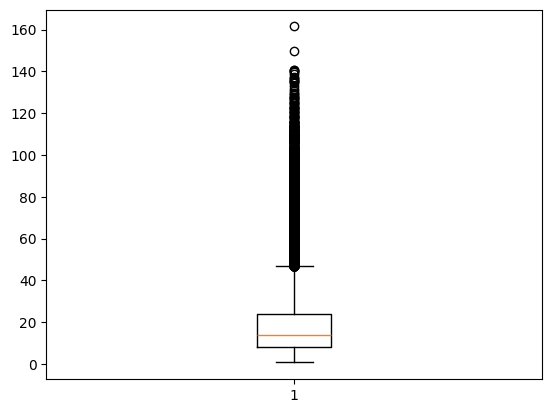

In [10]:
plt.boxplot(test_df['price'])

In [11]:
test_df[['sample_id', 'price']].to_csv('submission.csv', index=False)

(array([22056., 33009., 11397.,  3098.,  2112.,  1761.,   747.,   384.,
          194.,   242.]),
 array([  6.066749 ,  19.5486391,  33.0305292,  46.5124193,  59.9943094,
         73.4761995,  86.9580896, 100.4399797, 113.9218698, 127.4037599,
        140.88565  ]),
 <BarContainer object of 10 artists>)

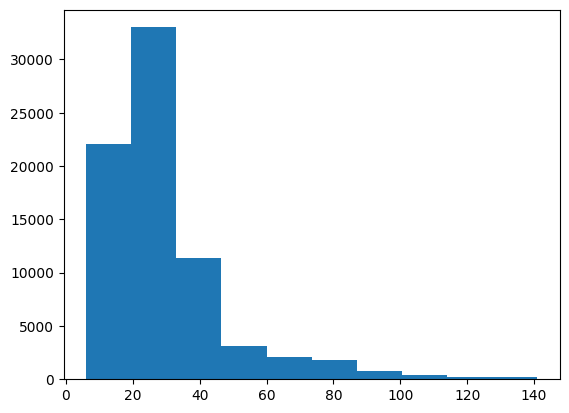

In [14]:
prev = pd.read_csv('prev.csv')
plt.hist(prev['price'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c549e994b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c549e99ab0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c549e991b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c549e9a0b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c549e9a3b0>],
 'means': []}

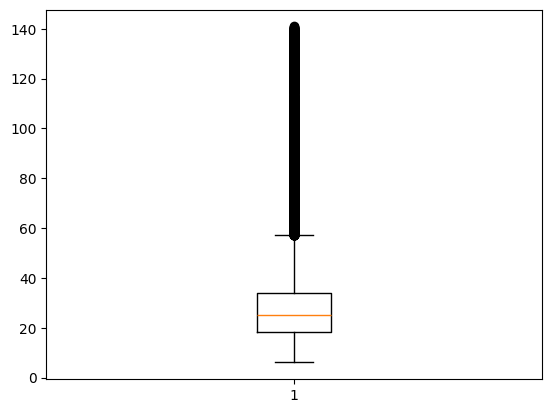

In [16]:
plt.boxplot(prev['price'])